In [38]:
%load_ext autoreload
%autoreload 2

import os.path
import numpy as np

# Load in data, this assumed you have a folder in env named data
data_dir = "data"
X_test = np.load(os.path.join(data_dir, "X_test.npy"))
y_test = np.load(os.path.join(data_dir, "y_test.npy"))
person_test = np.load(os.path.join(data_dir, "person_test.npy")).squeeze(axis=1)
X_train_valid = np.load(os.path.join(data_dir, "X_train_valid.npy"))
y_train_valid = np.load(os.path.join(data_dir, "y_train_valid.npy"))
person_train_valid = np.load(os.path.join(data_dir, "person_train_valid.npy")).squeeze(axis=1)

# Predefine some useful variables and fix data a bit
n_class = len(set(y_train_valid))
n_trials = 5
min_y = min(y_train_valid)
y_train_valid = y_train_valid - min_y
y_test = y_test - min_y

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
# Validate data loaded in correctly and print shapes
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'. format (X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115,)
Person test shape: (443,)


In [41]:
import random
import torch

# Define random seed so that we can reproduce results
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# This is for macbook M1, if you have intel I think you use cuda not mps
# Research what works for your device and change the torch.device
device = torch.device("cuda")
device

device(type='cuda')

In [42]:
# Import the models and functions
from models import *
from trainer import *
import matplotlib.pyplot as plt

In [43]:
# Set up data sets
s1_indices_train = [i for i, s in enumerate(person_train_valid) if s == 0]
s1_indices_test = [i for i, s in enumerate(person_test) if s == 0]
X_train_valid_s1 = X_train_valid[s1_indices_train]
y_train_valid_s1 = y_train_valid[s1_indices_train]
X_test_s1 = X_test[s1_indices_test]
y_test_s1 = y_test[s1_indices_test]

# Make dataloader test set for the single subject
# Convert data to tensors
X_tensor = torch.FloatTensor(X_test_s1)
y_tensor = torch.LongTensor(y_test_s1)

# Combine X and y into a TensorDataset
dataset = TensorDataset(X_tensor, y_tensor)

# Prepare dataloaders
test_dataloader_s1 = DataLoader(dataset, batch_size=256, shuffle=False)

# Train for the single subject data
Currently using low epochs just for testing purposes

## EEGnet (CNN)

  0%|          | 0/200 [00:00<?, ?it/s]

Best valid accuracy: 0.5625


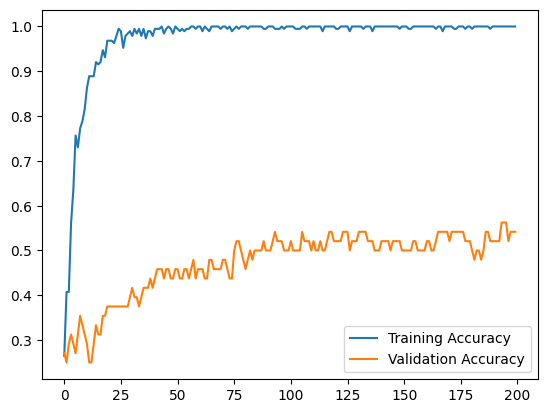

(0.5625, 0.52)

In [44]:
num_epochs=200

cnn = CNN(input_size=X_train_valid_s1.shape[1:], N=n_class).to(device)
valid_acc, trains, valids = fit(cnn, X_train_valid_s1, y_train_valid_s1, device, epochs=num_epochs)
plt.figure()
plt.plot(range(num_epochs), trains)
plt.plot(range(num_epochs), valids)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()
test_acc_cnn, _ = evaluate(cnn, test_dataloader_s1, device)

valid_acc, test_acc_cnn

### Test relationship between EEGnet single subject validation and test error (Done using Subject 2)

0.17004552278931725
0.09075692855206278


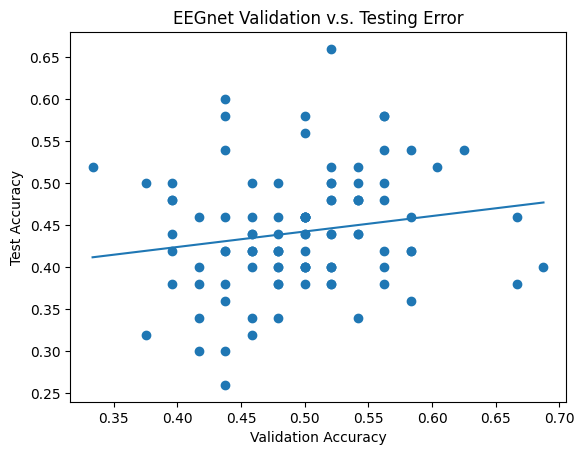

In [ ]:
# import scipy

# plt.scatter(valid_accs, test_accs)
# plt.plot(np.unique(valid_accs), np.poly1d(np.polyfit(valid_accs, test_accs, 1))(np.unique(valid_accs)))
# slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(valid_accs, test_accs)
# plt.xlabel("Validation Accuracy")
# plt.ylabel("Test Accuracy")
# plt.title("EEGnet Validation v.s. Testing Error")
# print(r_value)
# print(p_value)

## Evaluating Subject 1 Trained network on all other subjects

In [45]:
# Set up data sets

single_subject_testers = []

for subject in range(9):
    
    s1_indices_test = [i for i, s in enumerate(person_test) if s == subject]

    X_test_s1 = X_test[s1_indices_test]
    y_test_s1 = y_test[s1_indices_test]

    # Make dataloader test set for the single subject
    # Convert data to tensors
    X_tensor = torch.FloatTensor(X_test_s1)
    y_tensor = torch.LongTensor(y_test_s1)

    # Combine X and y into a TensorDataset
    dataset = TensorDataset(X_tensor, y_tensor)

    # Prepare dataloaders
    test_dataloader = DataLoader(dataset, batch_size=256, shuffle=False)
    single_subject_testers.append(test_dataloader)

Text(0.5, 1.0, 'Subject 1 Model classifying All Subjects')

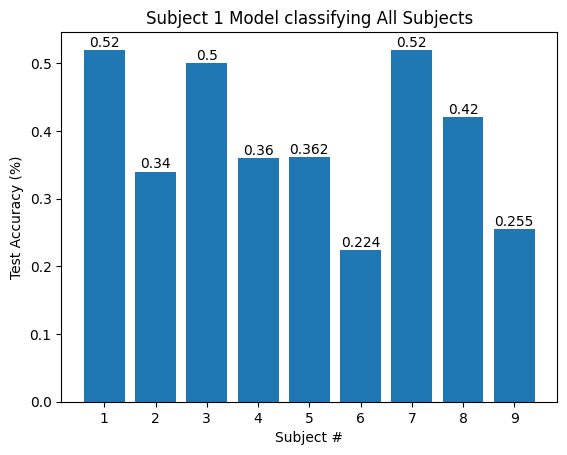

In [116]:
subject_test_acc = []

subject_test_acc.append(test_acc_cnn)

for i in range(8):
    test_acc, _ = evaluate(cnn, single_subject_testers[i+1], device)
    subject_test_acc.append(round(test_acc,3))

bars = plt.bar(np.arange(1, 10), subject_test_acc)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.4, yval + .005, yval, horizontalalignment="center")
plt.xticks(np.arange(1,10))
plt.xlabel("Subject #")
plt.ylabel("Test Accuracy (%)")
plt.title("Subject 1 Model classifying All Subjects")

## RNN (LSTM)

  0%|          | 0/200 [00:00<?, ?it/s]

Best valid accuracy: 0.35417


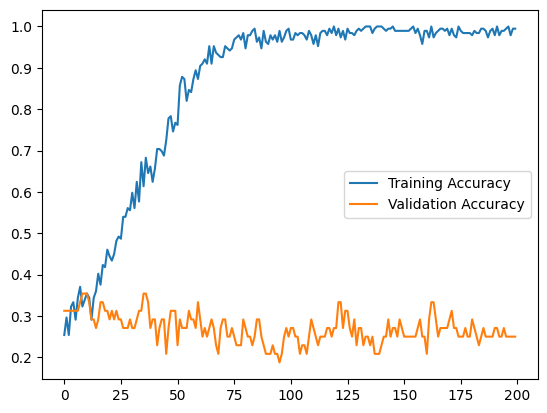

(0.35417, 0.2)

In [47]:
num_epochs=200

lstm = LSTM().to(device)
valid_acc, trains, valids = fit(lstm, X_train_valid_s1, y_train_valid_s1, device, epochs=num_epochs)
plt.figure()
plt.plot(range(num_epochs), trains)
plt.plot(range(num_epochs), valids)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()
test_acc, _ = evaluate(lstm, test_dataloader_s1, device)

valid_acc, test_acc

## Another RNN (GRU)

GRU takes super long to train, not entirely sure why

I even cut out a fc layer to speed it up, and increase lr

  0%|          | 0/200 [00:00<?, ?it/s]

Best valid accuracy: 0.33333


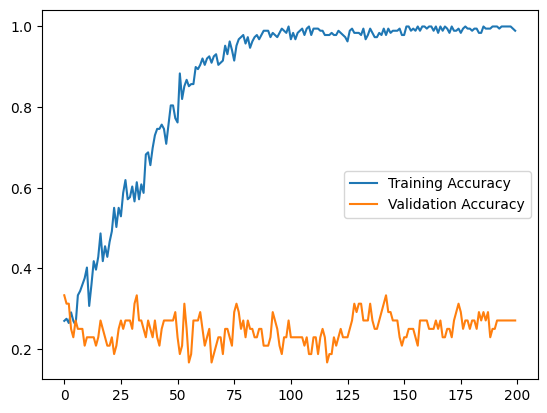

(0.33333, 0.24)

In [48]:
num_epochs=200

gru = GRU().to(device)
valid_acc, trains, valids = fit(gru, X_train_valid_s1, y_train_valid_s1, device, epochs=num_epochs)
plt.figure()
plt.plot(range(num_epochs), trains)
plt.plot(range(num_epochs), valids)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()
test_acc, _ = evaluate(gru, test_dataloader_s1, device)

valid_acc, test_acc

# Parkinson's CRNN

  0%|          | 0/250 [00:00<?, ?it/s]

Best valid accuracy: 0.33333


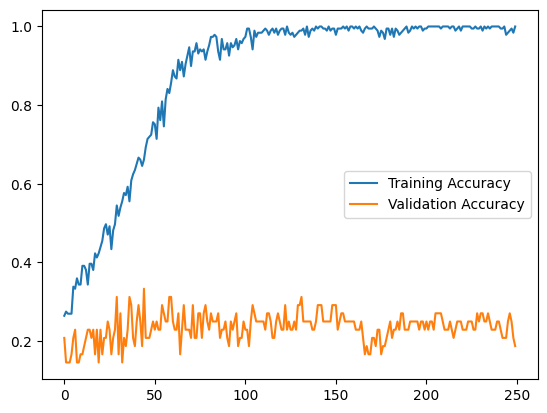

(0.33333, 0.3)

In [51]:
num_epochs=250

pdc = PD_CRNN(output_size=n_class).to(device)
valid_acc, trains, valids = fit(pdc, X_train_valid_s1, y_train_valid_s1, device, epochs=num_epochs)
plt.figure()
plt.plot(range(num_epochs), trains)
plt.plot(range(num_epochs), valids)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()
test_acc, _ = evaluate(pdc, test_dataloader_s1, device)

valid_acc, test_acc

## Tonmoy CRNN

  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.41667


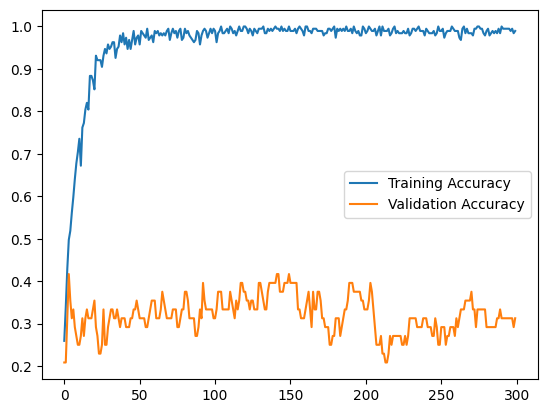

(0.41667, 0.3)

In [52]:
num_epochs=300

tonmoy = HybridCNNLSTM().to(device)
valid_acc, trains, valids = fit(tonmoy, X_train_valid_s1, y_train_valid_s1, device, epochs=num_epochs)
plt.figure()
plt.plot(range(num_epochs), trains)
plt.plot(range(num_epochs), valids)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()
test_acc, _ = evaluate(tonmoy, test_dataloader_s1, device)

valid_acc, test_acc

# Training for all subjects

In [53]:
# Make data loader for all subjects

# Convert data to tensors
X_tensor_full = torch.FloatTensor(X_test)
y_tensor_full = torch.LongTensor(y_test)

# Combine X and y into a TensorDataset
dataset_full = TensorDataset(X_tensor_full, y_tensor_full)

# Prepare dataloaders
test_dataloader_full = DataLoader(dataset_full, batch_size=256, shuffle=False)

## EEGnet (CNN) 

  0%|          | 0/500 [00:00<?, ?it/s]

Best valid accuracy: 0.71868


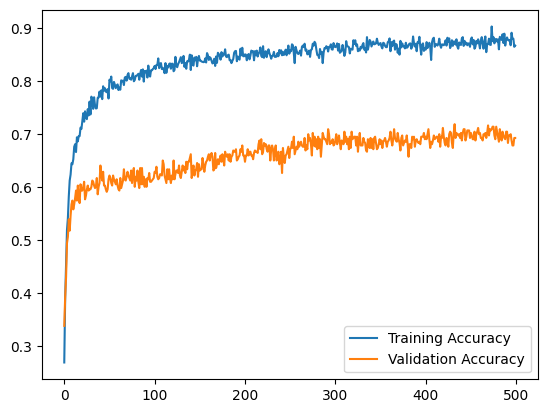

(0.71868, 0.68397)

In [66]:
num_epochs=500

cnn_all = CNN(input_size=X_train_valid.shape[1:], N=n_class, dropout_p=0.5).to(device)
valid_acc, trains, valids = fit(cnn_all, X_train_valid, y_train_valid, device, epochs=num_epochs)
plt.figure()
plt.plot(range(num_epochs), trains)
plt.plot(range(num_epochs), valids)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()
test_acc, _ = evaluate(cnn_all, test_dataloader_full, device)

valid_acc, test_acc

## Evaluating All Subject Model on each subject individually:

Text(0.5, 1.0, 'All Subject Model Performance per Subject')

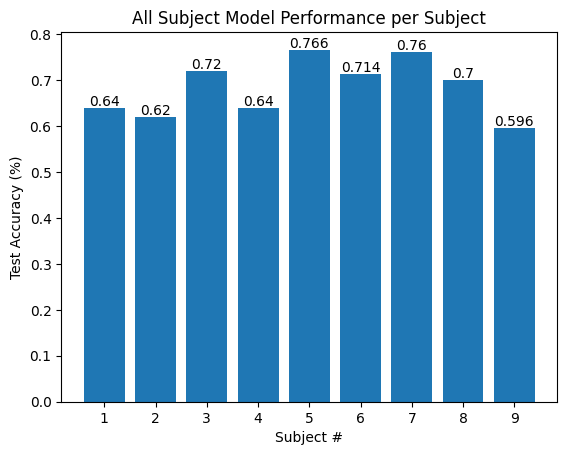

In [114]:
subject_test_acc = []

for i in range(9):
    test_acc, _ = evaluate(cnn_all, single_subject_testers[i], device)
    subject_test_acc.append(round(test_acc,3))

bars = plt.bar(np.arange(1, 10), subject_test_acc)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.4, yval + .005, yval, horizontalalignment="center")
plt.xticks(np.arange(1,10))
plt.xlabel("Subject #")
plt.ylabel("Test Accuracy (%)")
plt.title("All Subject Model Performance per Subject")

## LSTM

  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.27896


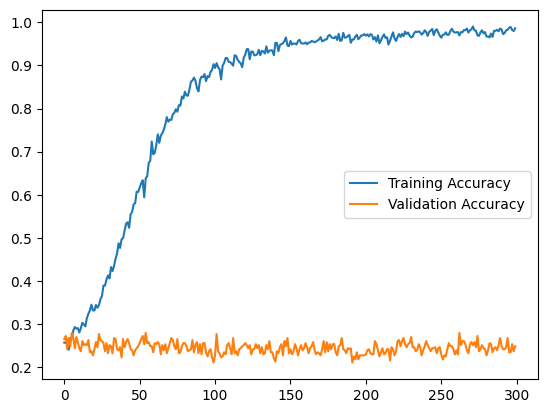

(0.27896, 0.22799)

In [58]:
num_epochs=300

lstm_all = LSTM().to(device)
valid_acc, trains, valids = fit(lstm_all, X_train_valid, y_train_valid, device, epochs=num_epochs)
plt.figure()
plt.plot(range(num_epochs), trains)
plt.plot(range(num_epochs), valids)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()
test_acc, _ = evaluate(lstm_all, test_dataloader_full, device)

valid_acc, test_acc

## GRU

  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.29078


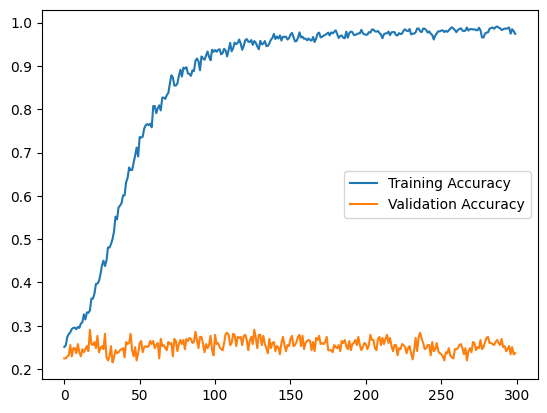

(0.29078, 0.26411)

In [59]:
num_epochs=300

gru_all = GRU().to(device)
valid_acc, trains, valids = fit(gru_all, X_train_valid, y_train_valid, device, epochs=num_epochs)
plt.figure()
plt.plot(range(num_epochs), trains)
plt.plot(range(num_epochs), valids)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()
test_acc, _ = evaluate(gru_all, test_dataloader_full, device)

valid_acc, test_acc

## Parkinson's identifying CRNN

  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.2766


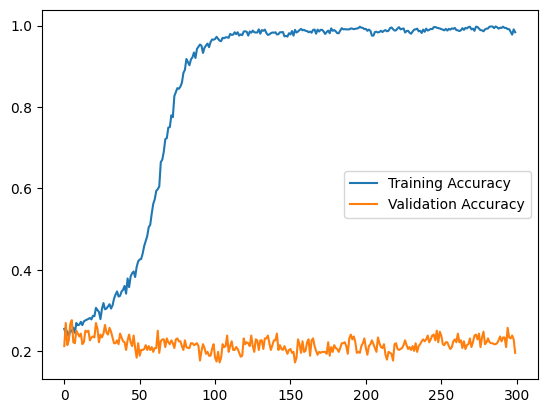

(0.2766, 0.23476)

In [60]:
num_epochs=300

pdc_all = PD_CRNN(output_size=n_class).to(device)
valid_acc, trains, valids = fit(pdc_all, X_train_valid, y_train_valid, device, epochs=num_epochs)
plt.figure()
plt.plot(range(num_epochs), trains)
plt.plot(range(num_epochs), valids)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()
test_acc, _ = evaluate(pdc_all, test_dataloader_full, device)

valid_acc, test_acc

## Tonmoy CRNN

  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.40898


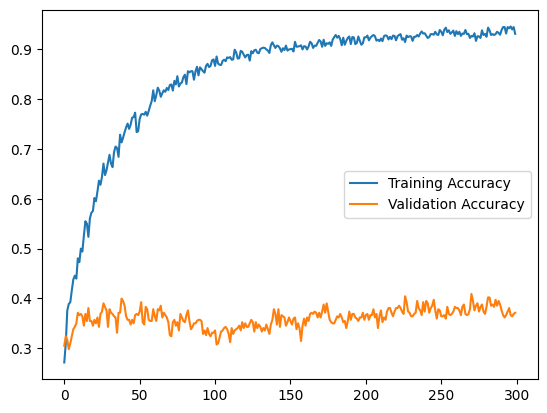

(0.40898, 0.35666)

In [61]:
num_epochs=300

tonmoy_all = HybridCNNLSTM().to(device)
valid_acc, trains, valids = fit(tonmoy_all, X_train_valid, y_train_valid, device, epochs=num_epochs)
plt.figure()
plt.plot(range(num_epochs), trains)
plt.plot(range(num_epochs), valids)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()
test_acc, _ = evaluate(tonmoy_all, test_dataloader_full, device)

valid_acc, test_acc

# Ensemble

Test the effect of ensembling models using max voting

## Lets train a CNN and CRNN, saving the y pred labels

In [16]:
# CNN
y_pred_CNN = []

print("Now training the CNN model\n")
for i in range(5):
    cnn = CNN(input_size=X_train_valid.shape[1:], N=n_class).to(device)
    fit(cnn, X_train_valid, y_train_valid, device, epochs=300)
    _, y_pred = evaluate(cnn, test_dataloader_full, device)
    y_pred_CNN.append(y_pred)

# # RNN (LSTM)
# y_pred_LSTM = []
# print("Now training the LSTM model\n")
# for i in range(n_trials):
#     rnn = LSTM().to(device)
#     fit(rnn, X_train_valid, y_train_valid, device, epochs=1)
#     _, y_pred = evaluate(rnn, test_dataloader_full, device)
#     y_pred_LSTM.append(y_pred)

# # CRNN
# y_pred_CRNN = []

# print("Now training the CRNN model\n")
# for i in range(n_trials):
#     crnn = PD_CRNN(output_size=n_class,).to(device)
#     fit(crnn, X_train_valid, y_train_valid, device, epochs=1)
#     _, y_pred= evaluate(crnn, test_dataloader_full, device)
#     y_pred_CRNN.append(y_pred)

# # CRNN
# y_pred_CRNN_2 = []

# print("Now training the CRNN2 model\n")
# for i in range(n_trials):
#     crnn2 = HybridCNNLSTM().to(device)
#     fit(crnn2, X_train_valid, y_train_valid, device, epochs=1)
#     _, y_pred= evaluate(crnn2, test_dataloader_full, device)
#     y_pred_CRNN_2.append(y_pred)

# Lets try max voting since thats used for classification tasks
def max_voting(*args):
    """
    Perform max voting ensemble for multiple classifiers.
    
    Args:
    *args: Arrays of predicted class labels from each classifier.
    
    Returns:
    Ensemble predictions based on max voting.
    """
    # Concatenate predicted labels along axis 1
    concatenated_predictions = np.concatenate(args, axis=0)
    
    # Find the most frequent prediction for each sample
    ensemble_predictions = np.array([np.argmax(np.bincount(sample_predictions)) for sample_predictions in concatenated_predictions.T])

    return ensemble_predictions

# Now lets try it out
# ensemble_predictions = max_voting(y_pred_CNN, y_pred_LSTM, y_pred_CRNN, y_pred_CRNN_2)
ensemble_predictions = max_voting(y_pred_CNN)

# Get accuracy of ensemble
correct = np.sum(ensemble_predictions == y_test)
total = len(y_test)
accuracy_ensemble = correct/total

print("Accuracy of ensemble: " + str(round(accuracy_ensemble, 5)))

Now training the CNN model



  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.68085


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.73995


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.69504


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.7305


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.71158
Accuracy of ensemble: 0.7246


In [68]:
# Output the model architectures
from torchinfo import summary

# EEGNet
EEGnet_summary = CNN(input_size=X_train_valid.shape[1:], N=n_class)
summary(EEGnet_summary, input_size=(64, 22, 1000))

# PD_CRNN
PD_CRNN_summary = PD_CRNN(output_size=n_class)
summary(PD_CRNN_summary, input_size=(64, 22, 1000))

Layer (type:depth-idx)                   Output Shape              Param #
PD_CRNN                                  [64, 4]                   --
├─Sequential: 1-1                        [64, 16, 22, 247]         --
│    └─Conv2d: 2-1                       [64, 16, 22, 991]         176
│    └─ReLU: 2-2                         [64, 16, 22, 991]         --
│    └─MaxPool2d: 2-3                    [64, 16, 22, 247]         --
│    └─Dropout: 2-4                      [64, 16, 22, 247]         --
├─Sequential: 1-2                        [64, 32, 2, 123]          --
│    └─Conv2d: 2-5                       [64, 32, 2, 247]          10,784
│    └─ReLU: 2-6                         [64, 32, 2, 247]          --
│    └─MaxPool2d: 2-7                    [64, 32, 2, 123]          --
│    └─Dropout: 2-8                      [64, 32, 2, 123]          --
├─Linear: 1-3                            [64, 123, 64]             4,160
├─LSTM: 1-4                              [123, 64, 128]            363,520
├─

### Incorrect, can probably remove

In [ ]:
# Demo new time_bin parameter for EEGNet
# turns out this is more of just cutting off training early?

num_epochs = 1
time_bins = range(500, 1000, 50)
train_accs = []
valid_accs = []

for i in time_bins:
    cnn_all = CNN(input_size=X_train_valid.shape[1:], N=n_class).to(device)
    valid_acc, trains, valids = fit(cnn_all, X_train_valid, y_train_valid, device, time_bin=i, epochs=num_epochs)
    train_accs.append(trains[0])  # Appending first epoch accuracy
    valid_accs.append(valids[0])  # Appending first epoch accuracy

plt.figure()
plt.plot(time_bins, train_accs, 'bo-', label='Training Accuracy')
plt.plot(time_bins, valid_accs, 'ro-', label='Validation Accuracy')
plt.title("Accuracy for Different Time Bins")
plt.xlabel('Time Bin')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Test Error v.s. Time Bins Used (400, 550, 700, 850, 1000)

In [95]:
# Diff time period 
import time 
ls = np.arange(400, 1001, 150)
train_accs = []
valid_accs = []
test_accs = []
times = []

for l in ls:
    print(f"{l=}")
    X_train_valid_sub = X_train_valid[:, :, :l]
    X_test_sub = X_test[:, :, :l]
     
    # make data loader
    # Convert data to tensors
    X_tensor_sub = torch.FloatTensor(X_test_sub)
    y_tensor_sub = torch.LongTensor(y_test)

    # Combine X and y into a TensorDataset
    dataset_sub = TensorDataset(X_tensor_sub, y_tensor_sub)

    # Prepare dataloaders
    test_dataloader_sub= DataLoader(dataset_sub, batch_size=256, shuffle=False)

    # CNN
    start = time.time()
    cnn_sub = CNN(input_size=X_train_valid_sub.shape[1:], N=n_class).to(device)
    valid_acc, trains, valids = fit(cnn_sub, X_train_valid_sub, y_train_valid, device, epochs=500)
    test_acc, _ = evaluate(cnn_sub, test_dataloader_sub, device)
    end = time.time()
    train_accs.append(trains)
    valid_accs.append(valids)
    test_accs.append(test_acc)
    times.append(end-start)


l=400


  0%|          | 0/500 [00:00<?, ?it/s]

Best valid accuracy: 0.73995
l=550


  0%|          | 0/500 [00:00<?, ?it/s]

Best valid accuracy: 0.76123
l=700


  0%|          | 0/500 [00:00<?, ?it/s]

Best valid accuracy: 0.75414
l=850


  0%|          | 0/500 [00:00<?, ?it/s]

Best valid accuracy: 0.73759
l=1000


  0%|          | 0/500 [00:00<?, ?it/s]

Best valid accuracy: 0.71395


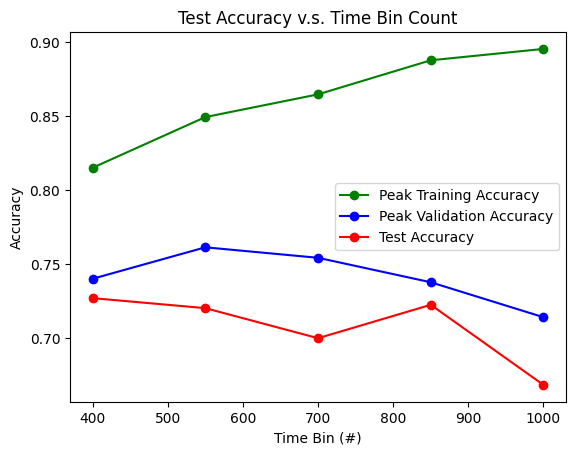

In [103]:
plt.figure()
plt.plot(ls, [np.max(x) for x in train_accs], 'go-')
plt.plot(ls, [np.max(x) for x in valid_accs], 'bo-')
plt.plot(ls, test_accs, 'ro-')
plt.title("Test Accuracy v.s. Time Bin Count")
plt.xlabel('Time Bin (#)')
plt.ylabel('Accuracy')
plt.legend(['Peak Training Accuracy', 'Peak Validation Accuracy', 'Test Accuracy'])
plt.show()

Text(0.5, 1.0, 'Total Training Time v.s. Time Bin Count')

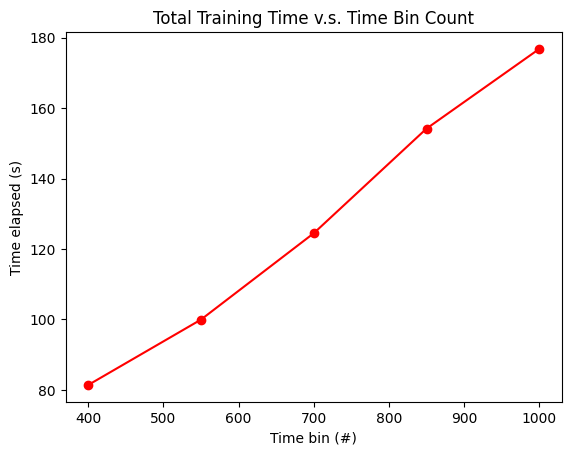

In [102]:
plt.figure()
plt.plot(ls, times, 'ro-')
plt.ylabel("Time elapsed (s)")
plt.xlabel("Time bin (#)")
plt.title("Total Training Time v.s. Time Bin Count")

## Test Error v.s. Time Bins Used (100, 200, 300, 400, 500, 600, 700)

In [104]:
ls = np.arange(100, 701, 100)
train_accs = []
valid_accs = []
test_accs = []
times = []

for l in ls:
    print(f"{l=}")
    X_train_valid_sub = X_train_valid[:, :, :l]
    X_test_sub = X_test[:, :, :l]
     
    # make data loader
    # Convert data to tensors
    X_tensor_sub = torch.FloatTensor(X_test_sub)
    y_tensor_sub = torch.LongTensor(y_test)

    # Combine X and y into a TensorDataset
    dataset_sub = TensorDataset(X_tensor_sub, y_tensor_sub)

    # Prepare dataloaders
    test_dataloader_sub= DataLoader(dataset_sub, batch_size=256, shuffle=False)

    # CNN
    start = time.time()
    cnn_sub = CNN(input_size=X_train_valid_sub.shape[1:], N=n_class).to(device)
    valid_acc, trains, valids = fit(cnn_sub, X_train_valid_sub, y_train_valid, device, epochs=500)
    test_acc, _ = evaluate(cnn_sub, test_dataloader_sub, device)
    end = time.time()
    train_accs.append(trains)
    valid_accs.append(valids)
    test_accs.append(test_acc)
    times.append(end-start)

l=100


  0%|          | 0/500 [00:00<?, ?it/s]

Best valid accuracy: 0.58629
l=200


  0%|          | 0/500 [00:00<?, ?it/s]

Best valid accuracy: 0.65721
l=300


  0%|          | 0/500 [00:00<?, ?it/s]

Best valid accuracy: 0.73286
l=400


  0%|          | 0/500 [00:00<?, ?it/s]

Best valid accuracy: 0.78723
l=500


  0%|          | 0/500 [00:00<?, ?it/s]

Best valid accuracy: 0.73286
l=600


  0%|          | 0/500 [00:00<?, ?it/s]

Best valid accuracy: 0.74941
l=700


  0%|          | 0/500 [00:00<?, ?it/s]

Best valid accuracy: 0.70922


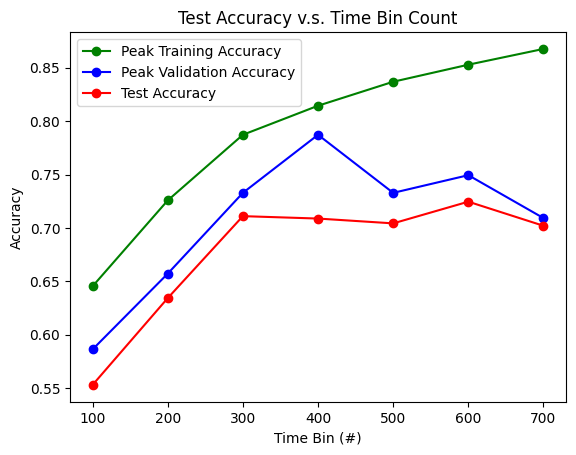

[0.55305, 0.63431, 0.71106, 0.7088, 0.70429, 0.7246, 0.70203]


In [107]:
plt.figure()
plt.plot(ls, [np.max(x) for x in train_accs], 'go-')
plt.plot(ls, [np.max(x) for x in valid_accs], 'bo-')
plt.plot(ls, test_accs, 'ro-')
plt.title("Test Accuracy v.s. Time Bin Count")
plt.xlabel('Time Bin (#)')
plt.ylabel('Accuracy')
plt.legend(['Peak Training Accuracy', 'Peak Validation Accuracy', 'Test Accuracy'])
plt.show()
print(test_accs)

Text(0.5, 1.0, 'Total Training Time v.s. Time Bin Count')

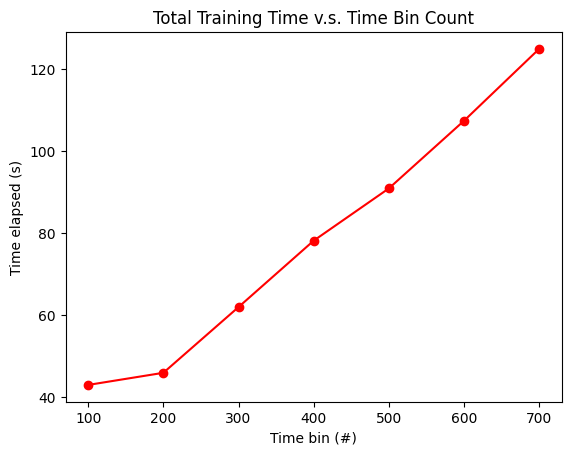

In [106]:
plt.figure()
plt.plot(ls, times, 'ro-')
plt.ylabel("Time elapsed (s)")
plt.xlabel("Time bin (#)")
plt.title("Total Training Time v.s. Time Bin Count")